In [1]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel
from mlp import MLP1, MLP2, encode_data

plt.style.use({'figure.facecolor':'white'})

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [3]:
model_path_1 = './model/haoran_mbd2/random_cliffords.pth'
# model_path_2 = './model/haoran_mbd2/random_circuits.pth'
model_path_3 = './model/haoran_mbd2/random_brickwork3.pth'
model_path_4 = './model/haoran_mbd2/mbd.pth'
model_path_5 = './model/haoran_mbd2/mlp_random_cliffords.pth'
model_path_6 = './model/haoran_mbd2/mlp_random_brickwork.pth'
model_path_7 = './model/haoran_mbd2/mlp_mbd.pth'

In [4]:
model_1 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_1.load_state_dict(torch.load(model_path_1))
model_1.eval()

# model_2 = ExpValCircuitGraphModel(
#     num_node_features=22,
#     hidden_channels=15
# )
# model_2.load_state_dict(torch.load(model_path_2))
# model_2.eval()
#
model_3 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_3.load_state_dict(torch.load(model_path_3))
model_3.eval()

model_4 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_4.load_state_dict(torch.load(model_path_4))
model_4.eval()

model_5 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_5.load_state_dict(torch.load(model_path_5))
model_5.eval()

model_6 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_6.load_state_dict(torch.load(model_path_6))
model_6.eval()

model_7 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_7.load_state_dict(torch.load(model_path_7))
model_7.eval()

MLP1(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [5]:
## Now we need to average over many disorders
num_disorders = 10

num_spins = 4 # Number of spins. Must be even.
W = 0.8 * np.pi # Disorder strength up to np.pi
theta = 0.05 * np.pi # Interaction strength up to np.pi
max_steps = 0

even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated_1 = []
imbalance_all_mitigated_2 = []
imbalance_all_mitigated_3 = []
imbalance_all_mitigated_4 = []
imbalance_all_mitigated_5 = []
imbalance_all_mitigated_6 = []
imbalance_all_mitigated_7 = []

exp_Z_all_ideal = []
exp_Z_all_noisy = []
exp_Z_all_mitigated_1 = []
exp_Z_all_mitigated_2 = []
exp_Z_all_mitigated_3 = []
exp_Z_all_mitigated_4 = []
exp_Z_all_mitigated_5 = []
exp_Z_all_mitigated_6 = []
exp_Z_all_mitigated_7 = []

for disorder_realization in tqdm_notebook(range(num_disorders)):
    disorders = generate_disorder(num_spins, W, seed=disorder_realization)
    # print(disorders)

    qc_list = []
    for steps in range(max_steps + 10):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated_1 = []
    exp_Z_mitigated_2 = []
    exp_Z_mitigated_3 = []
    exp_Z_mitigated_4 = []
    exp_Z_mitigated_5 = []
    exp_Z_mitigated_6 = []
    exp_Z_mitigated_7 = []


    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        graph_data = circuit_to_graph_data_json(
            circuit=transpiled_qc_list[i],
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[noisy_exp_val.tolist()],
            circuit_depth=transpiled_qc_list[i].depth()
        ).to_pyg_data()

        # print(entry.batch)
        mitigated_exp_val_1 = model_1(entry.noisy_0,
                            entry.observable,
                            entry.circuit_depth,
                            entry.x,
                            entry.edge_index,
                            entry.batch).tolist()[0]
        exp_Z_mitigated_1.append(mitigated_exp_val_1)

        # mitigated_exp_val_2 = model_2(entry.noisy_0,
        #                     entry.observable,
        #                     entry.circuit_depth,
        #                     entry.x,
        #                     entry.edge_index,
        #                     entry.batch).tolist()[0]
        # exp_Z_mitigated_2.append(mitigated_exp_val_2)

        mitigated_exp_val_3 = model_3(entry.noisy_0,
                            entry.observable,
                            entry.circuit_depth,
                            entry.x,
                            entry.edge_index,
                            entry.batch).tolist()[0]
        exp_Z_mitigated_3.append(mitigated_exp_val_3)

        mitigated_exp_val_4 = model_4(entry.noisy_0,
                            entry.observable,
                            entry.circuit_depth,
                            entry.x,
                            entry.edge_index,
                            entry.batch).tolist()[0]
        exp_Z_mitigated_4.append(mitigated_exp_val_4)

        X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

        mitigated_exp_val_5 = model_5(X).tolist()[0]
        exp_Z_mitigated_5.append(mitigated_exp_val_5)

        mitigated_exp_val_6 = model_6(X).tolist()[0]
        exp_Z_mitigated_6.append(mitigated_exp_val_6)

        mitigated_exp_val_7 = model_7(X).tolist()[0]
        exp_Z_mitigated_7.append(mitigated_exp_val_7)

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated_1 = calc_imbalance(exp_Z_mitigated_1, even_qubits, odd_qubits)
    # imbalance_mitigated_2 = calc_imbalance(exp_Z_mitigated_2, even_qubits, odd_qubits)
    imbalance_mitigated_3 = calc_imbalance(exp_Z_mitigated_3, even_qubits, odd_qubits)
    imbalance_mitigated_4 = calc_imbalance(exp_Z_mitigated_4, even_qubits, odd_qubits)
    imbalance_mitigated_5 = calc_imbalance(exp_Z_mitigated_5, even_qubits, odd_qubits)
    imbalance_mitigated_6 = calc_imbalance(exp_Z_mitigated_6, even_qubits, odd_qubits)
    imbalance_mitigated_7 = calc_imbalance(exp_Z_mitigated_7, even_qubits, odd_qubits)

    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated_1.append(imbalance_mitigated_1)
    # imbalance_all_mitigated_2.append(imbalance_mitigated_2)
    imbalance_all_mitigated_3.append(imbalance_mitigated_3)
    imbalance_all_mitigated_4.append(imbalance_mitigated_4)
    imbalance_all_mitigated_5.append(imbalance_mitigated_5)
    imbalance_all_mitigated_6.append(imbalance_mitigated_6)
    imbalance_all_mitigated_7.append(imbalance_mitigated_7)

    exp_Z_all_ideal.append(exp_Z_ideal)
    exp_Z_all_noisy.append(exp_Z_noisy)
    exp_Z_all_mitigated_1.append(exp_Z_mitigated_1)
    exp_Z_all_mitigated_2.append(exp_Z_mitigated_2)
    exp_Z_all_mitigated_3.append(exp_Z_mitigated_3)
    exp_Z_all_mitigated_4.append(exp_Z_mitigated_4)
    exp_Z_all_mitigated_5.append(exp_Z_mitigated_5)
    exp_Z_all_mitigated_6.append(exp_Z_mitigated_6)
    exp_Z_all_mitigated_7.append(exp_Z_mitigated_7)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average_1 = np.mean(imbalance_all_mitigated_1, axis=0)
imbalance_mitigated_average_2 = np.mean(imbalance_all_mitigated_2, axis=0)
imbalance_mitigated_average_3 = np.mean(imbalance_all_mitigated_3, axis=0)
imbalance_mitigated_average_4 = np.mean(imbalance_all_mitigated_4, axis=0)
imbalance_mitigated_average_5 = np.mean(imbalance_all_mitigated_5, axis=0)
imbalance_mitigated_average_6 = np.mean(imbalance_all_mitigated_6, axis=0)
imbalance_mitigated_average_7 = np.mean(imbalance_all_mitigated_7, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# """Save all charge imbalance"""
# to_save = {
#     'exp_Z_ideal': exp_Z_all_ideal,
#     'exp_Z_noisy': exp_Z_all_noisy,
#     'exp_Z_mitigated_rand_cliff': exp_Z_all_mitigated_1,
#     'exp_Z_mitigated_rand_circ': exp_Z_all_mitigated_2,
#     'exp_Z_mitigated_rand_brick': exp_Z_all_mitigated_3,
#     'exp_Z_mitigated_mbd': exp_Z_all_mitigated_4,
#
#     'ideal_average': list(imbalance_ideal_average),
#     'noisy_average': list(imbalance_noisy_average),
#     'mitigated_average_random_cliff': list(imbalance_mitigated_average_1),
#     'mitigated_average_random_circ': list(imbalance_mitigated_average_2),
#     'mitigated_average_random_brick': list(imbalance_mitigated_average_3),
#     'mitigated_average_mbd': list(imbalance_mitigated_average_4)
# }
#
# with open('./results_to_plot/mbd/charge_imbal_at_steps.json', 'w') as f:
#     json.dump(to_save, f)

In [12]:
# with open('./single_z_exp_at_steps.json', 'r') as f:
#     d = json.load(f)

# for key, val in d.items():
#     print(key, '\n', np.mean(np.array(val)[:, 0], 0))

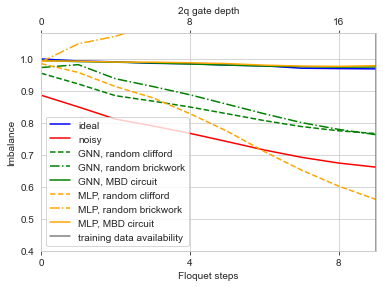

In [7]:
## Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(imbalance_ideal_average, color='blue', label="ideal")
ax1.plot(imbalance_noisy_average, color='red', label="noisy")
ax1.plot(imbalance_mitigated_average_1, color='green', label="GNN, random clifford", linestyle='dashed')
# ax1.plot(imbalance_mitigated_average_2, color='green', label="GNN, random circuit", linestyle='dashed')
ax1.plot(imbalance_mitigated_average_3, color='green', label="GNN, random brickwork", linestyle='-.')
ax1.plot(imbalance_mitigated_average_4, color='green', label="GNN, MBD circuit", linestyle='solid')
ax1.plot(imbalance_mitigated_average_5, color='orange', label="MLP, random clifford", linestyle='dashed')
ax1.plot(imbalance_mitigated_average_6, color='orange', label="MLP, random brickwork", linestyle='-.')
ax1.plot(imbalance_mitigated_average_7, color='orange', label="MLP, MBD circuit", linestyle='solid')

ax1.axvline(x = 9, color = 'gray', label = 'training data availability')

ax1.set_xlabel('Floquet steps')
ax1.set_ylabel('Imbalance')
ax1.legend()

xmin, xmax = ax1.get_xlim()
max_x = max_steps + 10
ax1.set_xlim([0, max_x-1])
ax2.set_xlim([0, max_x-1])
ax1.set_ylim([0.4, 1.08])
ax1.set_xticks(np.arange(0, max_x, 4))
x2 = np.linspace(xmin, xmax, 50)
ax2.plot(x2, -np.ones(50)) # Create a dummy plot
ax2.set_xticks(np.arange(0, max_x, 4))
ax2.set_xticklabels(2*np.arange(0, max_x, 4))
ax2.set_xlabel(r"2q gate depth")
# ax1.grid(None)
ax2.grid(None)

plt.style.use({'figure.facecolor':'white'})
plt.show()